AUTHOR: Melissa Morris

DATE: 08/18/2017

NAME: center_finding.ipynb

DESCRIPTION: goes over various methods used to detect the center of the galaxy

# Center Finding Methods

So far, I have used three different methods, not including halo finder.

The most reliable way to do this is using Jason's method combined with the dark matter density method, which is what is currently being used as galaxy_center in the siman script.

In [15]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from edgefinder import *
import scipy.optimize as opt
from yt.units import kpc,cm,km,s
from yt import derived_field
from astropy.table import Table
%matplotlib inline

In [17]:
'''
Jason's method:
  Does some magic

pros:
  - quick
  - literally don't need any kind of starting point

cons:
  - not very accurate on its own, especially if merger is happening

'''

def galaxy_center(filename):
    track = Table.read('/astro/simulations/FOGGIE/'+filename[26:-14]+'/halo_track', format='ascii') 
    track.sort('col1')

    # load the snapshot 
    global ds
    ds = yt.load(filename)
    zsnap = ds.get_parameter('CosmologyCurrentRedshift')
    
    # interpolate the center from the track
    centerx = np.interp(zsnap, track['col1'], track['col2']) 
    centery = np.interp(zsnap, track['col1'], track['col3']) 
    centerz = 0.5 * ( np.interp(zsnap, track['col1'], track['col4']) + np.interp(zsnap, track['col1'], track['col7'])) 

    cen = [centerx, centery+20. / 143886., centerz]
    return ds,cen

In [18]:
'''
Directional Profile Method
   Calculates velocity profile along x, y, and z axes, finds the maximum, and sets that
   as the center

pros:
  - fairly accurate
  
cons:
  - broken af
  - need Jason's method first
  - seriously it's like super broken don't use it

'''

# Makes density profile along one direction
def make_profile(ds,cen,rad,xyz):
    sph = ds.sphere(cen, (rad,'kpc'))
    rp = yt.create_profile(sph, xyz, 'density',
                          logs = {'density': True})
    return rp.x.value,rp["density"].value

# Finds max value of density profile along one direction
def find_max(ds,cen,rad,xyz):
    g,gdens = make_profile(ds,cen,rad,xyz)
    maxim = np.where(gdens == np.max(gdens))[0]
    return g[maxim][0]

# Does the two above things for each direction
def find_gal_center(ds,cen,rad):
    coord = ['x','y','z']
    newcenter = []
    for i in coord:
        newcenter.append(find_max(ds,cen,rad,i))
    return newcenter

In [34]:
'''
Dark Matter Density Method
   finds the point with the highest dark matter density and sets that as the center

pros:
   - super ez
   - works fairly well
   
cons:
   - sometimes picks wrong galaxy
   - needs Jason's method

'''

def dm_dens(file_name):
    ds,near_center = galaxy_center(file_name)
    sph = ds.sphere(near_center, (50,'kpc'))
    best = np.where(np.max(sph['dark_matter_density'])==sph['dark_matter_density'])[0][0]
    center = [sph['x'][best],sph['y'][best],sph['z'][best]]
    return ds,sph,center

In [39]:
filename = '/astro/simulations/FOGGIE/halo_008508/nref10_track_lowfdbk_1/DD0057/DD0057'
L = [-0.56197719,  0.56376017,  0.60527358]
Lx = [ 0.,          0.73175552, -0.6815672 ]

yt : [INFO     ] 2017-07-13 12:03:07,070 Parameters: current_time              = 276.816562817
yt : [INFO     ] 2017-07-13 12:03:07,071 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2017-07-13 12:03:07,072 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-13 12:03:07,073 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-07-13 12:03:07,074 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-07-13 12:03:07,075 Parameters: current_redshift          = 0.992497602714
yt : [INFO     ] 2017-07-13 12:03:07,076 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2017-07-13 12:03:07,076 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2017-07-13 12:03:07,077 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|██████████| 2394/2394 [00:00<00:00, 19133.46it/s]
yt : [INFO     ] 2017-07-13 12:03:07,390 Gathering a field list (this may take a moment.)
yt : [INFO     


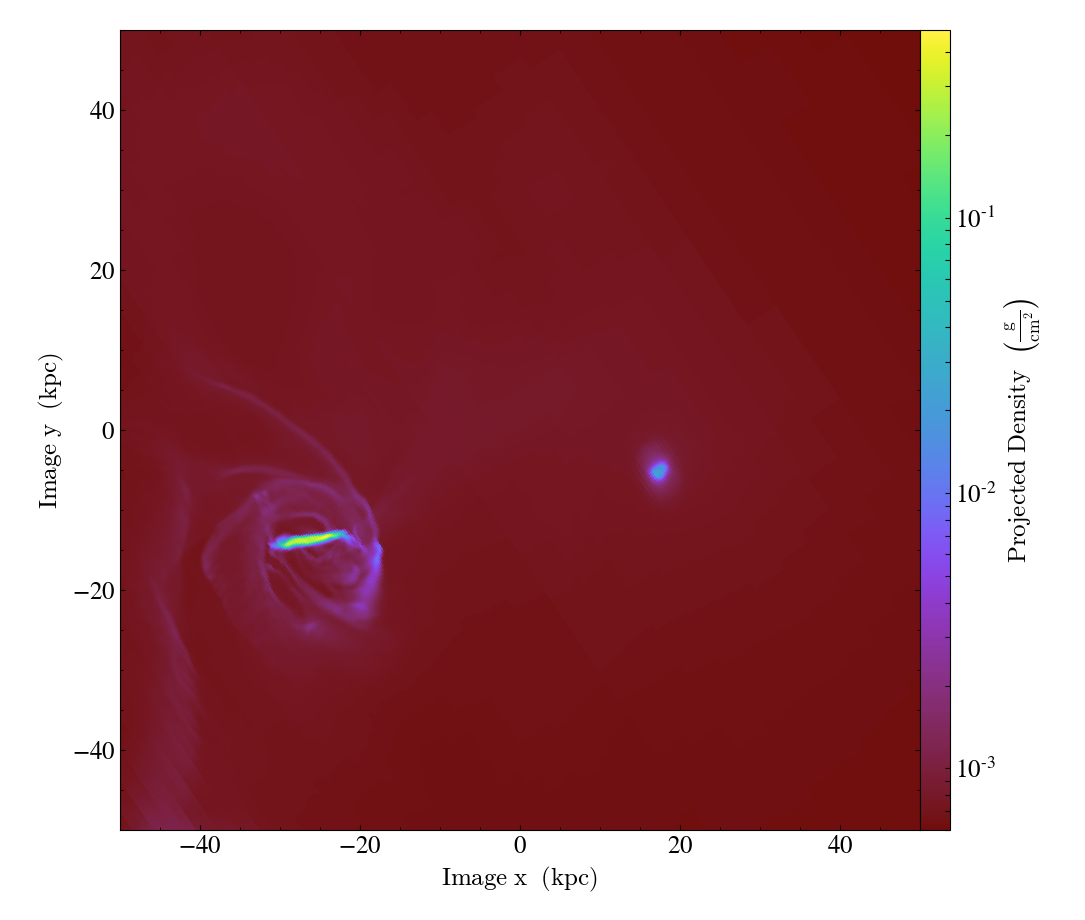

In [40]:
ds,jcent = galaxy_center(filename)
oap = yt.OffAxisProjectionPlot(ds,Lx,'density',center=jcent,width=(100,'kpc'),north_vector=L)
oap.show()

yt : [INFO     ] 2017-07-13 12:04:48,251 Parameters: current_time              = 276.816562817
yt : [INFO     ] 2017-07-13 12:04:48,252 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2017-07-13 12:04:48,253 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-13 12:04:48,255 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-07-13 12:04:48,256 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-07-13 12:04:48,257 Parameters: current_redshift          = 0.992497602714
yt : [INFO     ] 2017-07-13 12:04:48,258 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2017-07-13 12:04:48,259 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2017-07-13 12:04:48,260 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|██████████| 2394/2394 [00:00<00:00, 34917.77it/s]
yt : [INFO     ] 2017-07-13 12:04:48,432 Gathering a field list (this may take a moment.)
yt : [INFO     


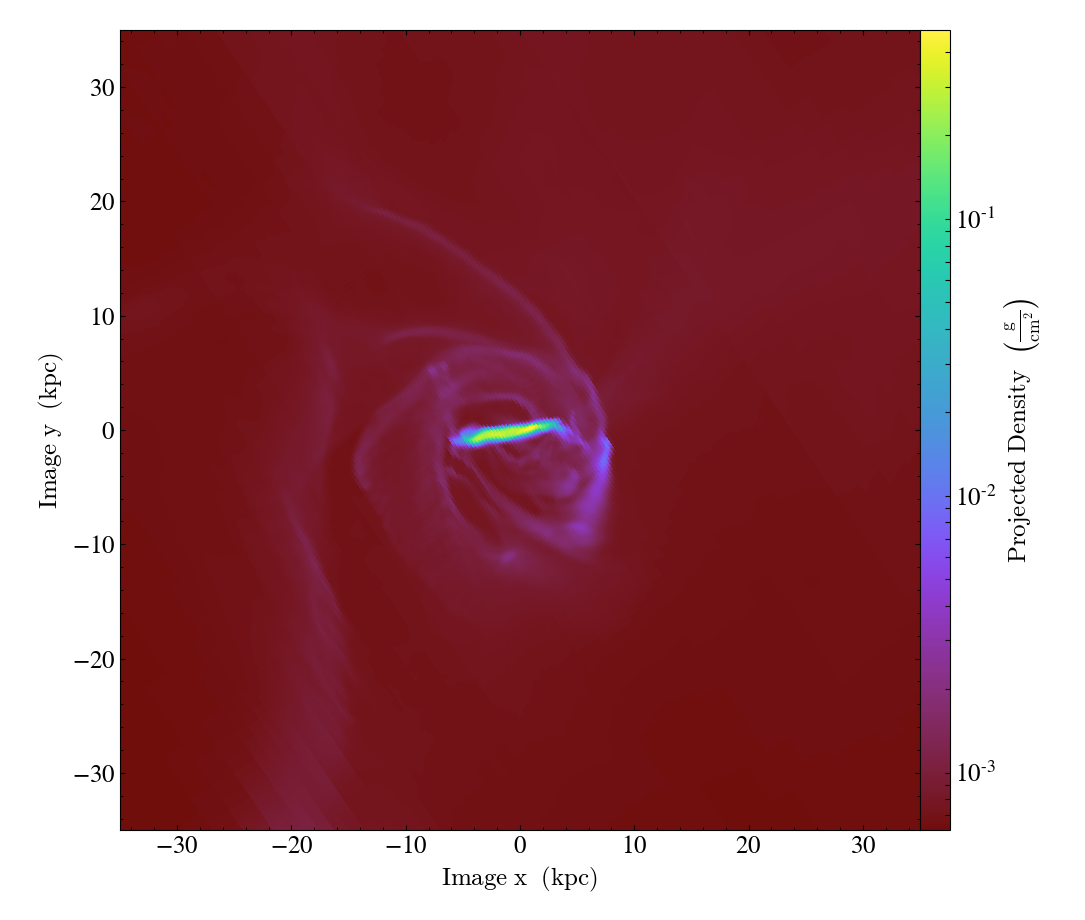

In [41]:
ds,sp,dmcent = dm_dens(filename)
oap = yt.OffAxisProjectionPlot(ds,Lx,'density',center=dmcent,width=(70,'kpc'),north_vector=L)
oap.show()